# Compute some new Edges


The following edge Computations will be performed

1. Disease sublcass Punning: Anything connected to a Disease will also have the same edge added to Diseases that are a subclass of that Disease (single level).

2. Anatomy Subclass Punning
3.  Disease to GO-Term edges via Fisher's Exact


In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from data_tools.plotting import count_plot_h
from data_tools import combine_nodes_and_edges
from data_tools.wiki import xref_to_wd_item, get_curi_xrefs
from data_tools.df_processing import combine_group_cols_on_char, split_col

# Recommended add
from tqdm.autonotebook import tqdm

/Users/sulhasan/opt/anaconda3/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
prev_dir = Path('../2_pipeline/01c_WikiData_Cleanup/out/').resolve()
nodes = pd.read_csv(prev_dir.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(prev_dir.joinpath('edges.csv'), dtype=str)

In [3]:
combo = combine_nodes_and_edges(nodes, edges)

In [4]:
new_edges = []

In [5]:
def pun_col(edge_to_pun, pun_map, pun_start=True):
    
    # Grab the correct columns
    if pun_start:
        pun_col = 'start_id'
        other_col = 'end_id'
    else:
        pun_col = 'end_id'
        other_col = 'start_id'

    # Ensure Punning Map does not include self
    drop_idx = pun_map[pun_map['start_id'] == pun_map['end_id']].index
    pun_map = pun_map.drop(drop_idx)
    
    pun_res = edge_to_pun.merge(pun_map, how='left', left_on=[pun_col], right_on=['end_id'], suffixes=('_orig', '_pun'))
        
    # if punning on end col, left and right are punned on end, so no suffix added... need to drop
    # this column
    if not pun_start:
        pun_res = pun_res.drop('end_id', axis=1)
    
    pun_res = pun_res.rename(columns={'start_id_pun': pun_col, other_col+'_orig': other_col})
    pun_res['dsrc_type'] = 'computed'
    pun_res['comp_type'] = 'punning'
    
    # Remove nan values, where there was no punning
    pun_res = pun_res.dropna(subset=[pun_col])
    
    return pun_res[['start_id', 'end_id', 'type', 'dsrc_type', 'comp_type']]

## Pun the diseases

In [6]:
start_dis = combo.query('start_label == "Disease" and type != "subclass_of"')
end_dis = combo.query('end_label == "Disease" and type != "subclass_of"')

disease_to_sub = combo.query('start_label == "Disease" and end_label == "Disease" and type == "subclass_of"')[['start_id', 'end_id']]

In [7]:
new_edges.append(pun_col(start_dis, disease_to_sub))
new_edges.append(pun_col(end_dis, disease_to_sub, False))

#### Recombine, so anatomy and disease terms are properly punned

In [8]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'])
combo = combine_nodes_and_edges(nodes, edges)
new_edges = []

## Anatomy Terms

In [9]:
start_ana = combo.query('start_label == "Anatomy" and type != "subclass_of"')
end_ana = combo.query('end_label == "Anatomy" and type != "subclass_of"')

anatomy_to_sub = combo.query('start_label == "Anatomy" and end_label == "Anatomy" and type == "subclass_of"')[['start_id', 'end_id']]

In [10]:
new_edges.append(pun_col(start_ana, anatomy_to_sub))
new_edges.append(pun_col(end_ana, anatomy_to_sub, False))

In [11]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'])
combo = combine_nodes_and_edges(nodes, edges)

## Examine Results

In [12]:
combo.query('start_label == "Disease" and comp_type == "punning"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
1479621,Q1544517,Q57769952,presents,computed,punning,oneiroid syndrome,catatonic excitement,Disease,Phenotype
1479622,Q18967220,Q57769952,presents,computed,punning,catatonic type schizophrenia subchronic state,catatonic excitement,Disease,Phenotype
1479623,Q18967223,Q57769952,presents,computed,punning,catatonic type schizophrenia chronic state wit...,catatonic excitement,Disease,Phenotype
1479624,Q55011031,Q57769952,presents,computed,punning,catatonic type schizophrenia chronic state,catatonic excitement,Disease,Phenotype
1479625,Q3445377,Q67135649,presents,computed,punning,regressive autism,autistic special interest,Disease,Phenotype
...,...,...,...,...,...,...,...,...,...
1489058,Q18556359,HP:0100575,presents,computed,punning,gallbladder angiosarcoma,gallbladder cancer,Disease,Phenotype
1489059,Q18557517,HP:0100575,presents,computed,punning,gallbladder papillary carcinoma,gallbladder cancer,Disease,Phenotype
1489060,Q19001059,HP:0100575,presents,computed,punning,metastatic neoplasm to the gallbladder,gallbladder cancer,Disease,Phenotype
1489061,Q19001064,HP:0100575,presents,computed,punning,gallbladder cancer unresectable,gallbladder cancer,Disease,Phenotype


In [13]:
combo.query('end_label == "Disease" and comp_type == "punning"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
703,Q2715597,Q4736375,causes,computed,punning,Alternaria solani,Alternariosis,Taxon,Disease
704,Q10406867,Q4736375,causes,computed,punning,Alternaria capsici-annui,Alternariosis,Taxon,Disease
705,Q62858638,Q18975970,causes,computed,punning,Bacteroides koreensis,bacteroides infectious disease,Taxon,Disease
706,Q4736364,Q4736375,causes,computed,punning,Alternaria linicola,Alternariosis,Taxon,Disease
707,Q4736362,Q4736375,causes,computed,punning,Alternaria japonica,Alternariosis,Taxon,Disease
...,...,...,...,...,...,...,...,...,...
2244962,Q29583412,Q33525,site_of,computed,punning,simple epithelium,carcinoma,Anatomy,Disease
2244963,Q29578507,Q33525,site_of,computed,punning,cuboidal epithelium,carcinoma,Anatomy,Disease
2244964,Q29578543,Q33525,site_of,computed,punning,columnar epithelium,carcinoma,Anatomy,Disease
2244965,Q29578493,Q33525,site_of,computed,punning,squamous epithelium,carcinoma,Anatomy,Disease


In [14]:
combo.query('end_label == "Disease" and comp_type == "punning" and type == "treats"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
2132332,Q415081,Q1193891,treats,computed,punning,donepezil,retrograde amnesia,Compound,Disease
2132333,Q415081,Q2555537,treats,computed,punning,donepezil,Lacunar amnesia,Compound,Disease
2132334,Q415081,Q2449188,treats,computed,punning,donepezil,Transient epileptic amnesia,Compound,Disease
2132335,Q415081,Q572111,treats,computed,punning,donepezil,anterograde amnesia,Compound,Disease
2132336,Q415081,Q4483652,treats,computed,punning,donepezil,fixation amnesia,Compound,Disease
...,...,...,...,...,...,...,...,...,...
2171241,Q27271655,Q54973000,treats,computed,punning,tenofovir disoproxil succinate,HIV seropositivity,Compound,Disease
2171242,Q27271655,Q12199,treats,computed,punning,tenofovir disoproxil succinate,HIV/AIDS,Compound,Disease
2171243,Q27032359,Q1451877,treats,computed,punning,doxorubicin hydrochloride,embryonal carcinoma,Compound,Disease
2171244,Q27032359,Q5370230,treats,computed,punning,doxorubicin hydrochloride,embryoma,Compound,Disease


In [15]:
combo.query('start_label == "Anatomy" and comp_type == "punning"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
2171246,Q9377,Q6934642,site_of,computed,punning,kidney,multicystic dysplastic kidney,Anatomy,Disease
2171247,Q9377,Q15443105,site_of,computed,punning,kidney,autosomal dominant polycystic kidney disease,Anatomy,Disease
2171248,Q9377,Q18558181,site_of,computed,punning,kidney,non-congenital cyst of kidney,Anatomy,Disease
2171249,Q9377,Q19000644,site_of,computed,punning,kidney,congenital cystic kidney disease,Anatomy,Disease
2171250,Q9377,Q60195313,site_of,computed,punning,kidney,polycystic kidney disease,Anatomy,Disease
...,...,...,...,...,...,...,...,...,...
2244962,Q29583412,Q33525,site_of,computed,punning,simple epithelium,carcinoma,Anatomy,Disease
2244963,Q29578507,Q33525,site_of,computed,punning,cuboidal epithelium,carcinoma,Anatomy,Disease
2244964,Q29578543,Q33525,site_of,computed,punning,columnar epithelium,carcinoma,Anatomy,Disease
2244965,Q29578493,Q33525,site_of,computed,punning,squamous epithelium,carcinoma,Anatomy,Disease


# Developing new Edges with stats tests

We can use a bridging concept (like genes) to bridge two other concepts, (like biological processes and diseases). Using a statistical test like Fisher's Exact, we can determine which Biological Processes have an association with which diseases.  

First let's look at what are linked to Genes or Proteins.

In [16]:
new_edges = []

In [17]:
combo.query('start_label == "Gene" or start_label == "Protein"')['end_label'].value_counts()

Taxon                 421051
Biological Process    278583
Cellular Component    236518
Molecular Function    205959
Protein               199878
Disease                36232
Phenotype                 46
Pathway                   29
Name: end_label, dtype: int64

In [18]:
combo.query('end_label == "Gene" or end_label == "Protein"')['start_label'].value_counts()

Gene        199877
Pathway      25185
Compound      3742
Protein          1
Name: start_label, dtype: int64

Can compute Disease to GO term, or Pathway

In [19]:
def get_item_to_gene_through_protein(item_label):
    pro_to_item = combo.query('start_label == "Protein" and end_label == @item_label')
    gene_to_pro = combo.query('start_label == "Gene" and end_label == "Protein" and type == "encodes"')

    item_to_gene = pro_to_item.merge(gene_to_pro, how='inner', left_on='start_id', right_on='end_id', suffixes=('_item', '_gene'))
    item_to_gene = item_to_gene.groupby('end_id_item')['start_id_gene'].apply(set).to_dict()
    return item_to_gene

In [20]:
# Not interested in non-human genes, so need to have them for filtering
tax_genes = set(combo.query('start_label == "Gene" and end_label == "Taxon"')['start_id'])

In [21]:
def filter_tax(mapper, keys=False):
    if keys:
        return {k: v for k, v in mapper.items() if k not in tax_genes}
    else:
        out = {k: {v for v in val if v not in tax_genes} for k, val in mapper.items()}
        out = {k: v for k, v in out.items() if len(v) > 0}
        return out

In [22]:
gene_to_dis = combo.query('start_label == "Gene" and end_label == "Disease"')
gene_to_dis = gene_to_dis.groupby('start_id')['end_id'].apply(set).to_dict()
gene_to_dis = filter_tax(gene_to_dis, keys=True)

dis_to_gene = combo.query('start_label == "Gene" and end_label == "Disease"')
dis_to_gene = dis_to_gene.groupby('end_id')['start_id'].apply(set).to_dict()
dis_to_gene = filter_tax(dis_to_gene)

In [23]:
dis_genes = set(chain(*dis_to_gene.values()))
    
def filter_to_disese_genes(mapper):
    out = {k: v&dis_genes for k, v in mapper.items()}
    out = {k: v for k, v in out.items() if len(v) > 0}
    return out

## BP associated_with Disease

In [24]:
bp_to_gene = get_item_to_gene_through_protein('Biological Process')
bp_to_gene = filter_tax(bp_to_gene)
bp_to_gene = filter_to_disese_genes(bp_to_gene)

In [25]:
def contingency_a_to_b_through_x(a_id, b_id, a_to_x_map, b_to_x_map, total):
    a_x = a_to_x_map[a_id]
    num_a_x = len(a_x)
    
    b_x = b_to_x_map[b_id]
    num_b_x = len(b_x)

    num_ab_x = len(a_x & b_x)
    
    num_not_a_or_b = total - len(a_x | b_x)
    
    return num_ab_x, num_a_x-num_ab_x, num_b_x-num_ab_x, num_not_a_or_b

In [26]:
from collections import defaultdict

In [27]:
def invert_one_to_many_map(mapper):
    inverted = defaultdict(set)
    for k, v_set in gene_to_dis.items():
        for v in v_set:
            inverted[v].add(k)
    return dict(inverted)

In [28]:
def run_all_compaisons(a_name, b_name, x_name, a_to_x_map, b_to_x_map, name_map, x_to_b_map=None):

    # Get the total number of X common to both conditions
    total = len(set(chain(*a_to_x_map.values())).intersection(set(chain(*b_to_x_map.values()))))

    # Need X to B to quickly determine what tests to do
    if x_to_b_map is None:
        x_to_b_map = invert_one_to_many_map(b_to_x_map)
    
    # Initalize output...
    out_data = {a_name: [],
                a_name+'_name': [],
                b_name: [],
                b_name+'_name': [],
                a_name+'_'+b_name+'_'+x_name+'s': [],
                'only_'+a_name+'_'+x_name+'s': [],
                'only_'+b_name+'_'+x_name+'s': [],
                'other_'+x_name+'s': [],
                'odd_r': [],
                'p_val': []}


    for a_id in tqdm(set(a_to_x_map.keys())):

        # Only test the subset of B vals that contain Xs common to A
        # Speeds things up, so really try to do this
        to_test = set.union(*[x_to_b_map.get(x, set()) for x in a_to_x_map[a_id]])

        if not to_test:
            continue
        
        a_item_name = name_map[a_id]

        for b_id in to_test:

            b_item_name = name_map[b_id]

            num_ab, num_a, num_b, num_remain = contingency_a_to_b_through_x(a_id, b_id, a_to_x_map, b_to_x_map, total)
            odd_r, p_val = fisher_exact([[num_ab, num_a],[num_b, num_remain]])

            out_data[a_name].append(a_id)
            out_data[a_name+'_name'].append(a_item_name)
            out_data[b_name].append(b_id)
            out_data[b_name+'_name'].append(b_item_name)
            out_data[a_name+'_'+b_name+'_'+x_name+'s'].append(num_ab)
            out_data['only_'+a_name+'_'+x_name+'s'].append(num_a)
            out_data['only_'+b_name+'_'+x_name+'s'].append(num_b)
            out_data['other_'+x_name+'s'].append(num_remain)
            out_data['odd_r'].append(odd_r)
            out_data['p_val'].append(p_val)


    return pd.DataFrame(out_data)


In [29]:
bp_to_dis_data = run_all_compaisons('bp', 'disease', 'gene', bp_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

In [30]:
def add_disease_wise_bonferroni_pval_correction(data, ini_alpha):
    
    out = data.copy()
    corr_factor = out['disease'].value_counts().to_dict()
    corr_factor_s = out['disease'].map(corr_factor)
    sig_thresh = ini_alpha / corr_factor_s
    out['adj_p'] = out['p_val'] * (ini_alpha / sig_thresh)
    out['is_sig'] = out['adj_p'] < ini_alpha
    
    return out

In [31]:
def add_disease_wise_benjamini_hochberg_pval_correction(data, ini_alpha):
    
    out = data.copy()
    
    # defineid as i
    rank = out.groupby('disease')['p_val'].rank().astype(int)

    # defineid as m
    total = out.groupby('disease').apply(len).to_dict()
    total = out['disease'].map(total)

    # The comparison value is (i/m)*Q where Q = desired FDR
    out['bh_val'] = (rank / total) * ini_alpha
    
    # Now the threshold is the highest p-val where p-val < (i/m)*Q
    is_less_than_iqm = out['p_val'] < out['bh_val']
    # Find the Highest pval
    thresh_map = out[is_less_than_iqm].groupby('disease')['p_val'].max().to_dict()
    out['thresh'] = out['disease'].map(thresh_map)
    
    # Do the significance test
    out['is_sig'] = out['p_val'] <= out['thresh'] 

    return out

In [32]:
def add_benjamini_hochberg_pval_correction(data, ini_alpha):
    
    out = data.copy()

    # defineid as i
    rank = out['p_val'].rank(method='first').astype(int)
    
    # defineid as m
    total = len(out)

    # The comparison value is (i/m)*Q where Q = desired FDR
    out['bh_val'] = (rank / total) * ini_alpha
    
    # Now the threshold is the highest p-val where p-val < (i/m)*Q
    is_greater = out['bh_val'] > out['p_val']
    # Find the Highest pval
    out['thresh'] = out[is_greater]['p_val'].max()

    # Do the significance test
    out['is_sig'] = out['p_val'] <= out['thresh']

    return out

In [33]:
# Going with an alpha values of 0.25 because we'd like higher recall
# for these associations
bp_to_dis_data = add_disease_wise_bonferroni_pval_correction(bp_to_dis_data, 0.25)

In [34]:
print("{:,} Comparisons".format(len(bp_to_dis_data)))
print("{:,} Number Significant".format(bp_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(bp_to_dis_data['is_sig'].sum() / len(bp_to_dis_data)))

484,126 Comparisons
78,189 Number Significant
0.162 Fraction Significant


## Do some plotting 

In [35]:
def get_plot_data(result):
    plot_data = pd.DataFrame()
    plot_data['num_sig'] = result.groupby('disease')['is_sig'].sum()

    plot_data['total_obs'] = result.groupby('disease').apply(len)
    plot_data['frac_sig'] = plot_data['num_sig'] / plot_data['total_obs']
    return plot_data

In [36]:
def plot_results(plot_data):

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(16)
    fig.set_figheight(6)

    sns.violinplot(y='total_obs', data=plot_data, cut=0, ax=ax[0])
    ax[0].set_title('Number of Comparisons')
    ax[0].set_ylabel('count')
    sns.violinplot(y='num_sig', data=plot_data, cut=0, ax=ax[1])
    ax[1].set_title('Number Significant')
    ax[1].set_ylabel('count')
    sns.violinplot(y='frac_sig', data=plot_data, cut=0, ax=ax[2])
    ax[2].set_title('Fraction Significant')
    ax[2].set_ylabel('fraction')

    for a in ax:
        a.tick_params(axis='x', which='both', bottom=False)

    fig.suptitle('Values Per Disease', fontsize=16);

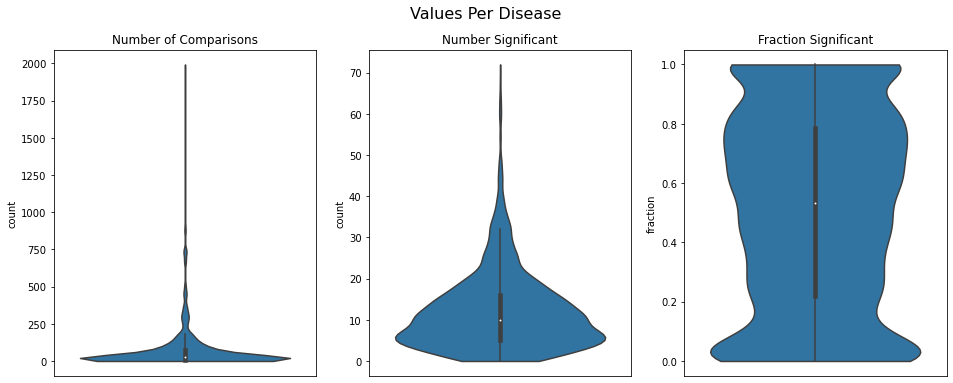

In [37]:
plot_results(get_plot_data(bp_to_dis_data))

## Create Edges

In [38]:
def comparisons_to_edges(comp_data, start_col, end_col):

    # Only take the signficant results
    out_data = comp_data.query('is_sig').copy()

    # Rename the approprate identifier columns
    out_data = out_data.rename(columns={start_col: 'start_id', end_col: 'end_id'})
    
    # give the correct types
    out_data['type'] = 'associated_with'
    out_data['dsrc_type'] = 'computed'
    out_data['comp_type'] = 'fishers_exact'
    
    # Return the data
    return out_data[['start_id', 'end_id', 'type', 'dsrc_type', 'comp_type', 'p_val', 'adj_p']]

In [39]:
this_edge = comparisons_to_edges(bp_to_dis_data, 'bp', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
8,Q21170205,Q18556319,associated_with,computed,fishers_exact,0.000229,0.020375
27,Q21170205,Q2069207,associated_with,computed,fishers_exact,0.000229,0.020375
32,Q22272350,Q945930,associated_with,computed,fishers_exact,0.001603,0.219551
33,Q22272350,Q8029730,associated_with,computed,fishers_exact,0.000229,0.008700
34,Q14758943,Q5958530,associated_with,computed,fishers_exact,0.000229,0.016255


In [40]:
new_edges.append(this_edge)

## MF associated_with Disease

In [41]:
mf_to_gene = get_item_to_gene_through_protein('Molecular Function')
mf_to_gene = filter_tax(mf_to_gene)
mf_to_gene = filter_to_disese_genes(mf_to_gene)

mf_to_dis_data = run_all_compaisons('mf', 'disease', 'gene', mf_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

156,109 Comparisons
30,585 Number Significant
0.196 Fraction Significant


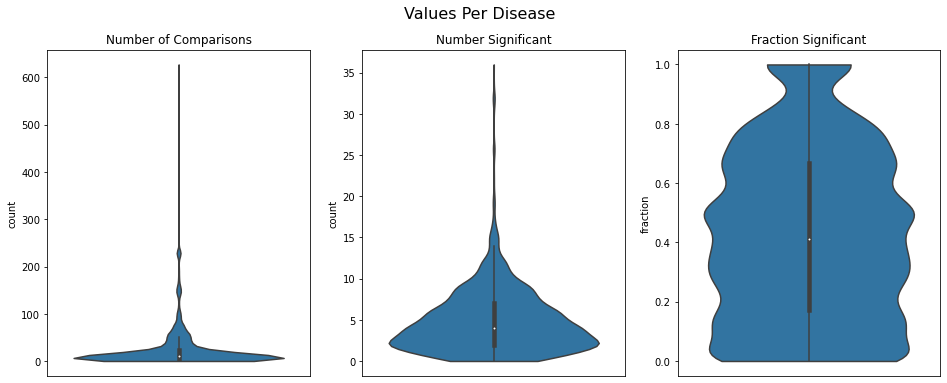

In [42]:
mf_to_dis_data = add_disease_wise_bonferroni_pval_correction(mf_to_dis_data, 0.25)

print("{:,} Comparisons".format(len(mf_to_dis_data)))
print("{:,} Number Significant".format(mf_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(mf_to_dis_data['is_sig'].sum() / len(mf_to_dis_data)))

plot_results(get_plot_data(mf_to_dis_data))

In [43]:
this_edge = comparisons_to_edges(mf_to_dis_data, 'mf', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
4,Q15329119,Q178194,associated_with,computed,fishers_exact,0.002806,0.089804
11,Q21132257,Q32144181,associated_with,computed,fishers_exact,0.000234,0.002106
12,Q14859820,Q15051322,associated_with,computed,fishers_exact,0.001063,0.072266
15,Q14859820,Q378681,associated_with,computed,fishers_exact,0.011203,0.168046
16,Q14859820,Q55782508,associated_with,computed,fishers_exact,0.001324,0.097967


In [44]:
new_edges.append(this_edge)

## CC associated_with Disease

In [45]:
cc_to_gene = get_item_to_gene_through_protein('Cellular Component')
cc_to_gene = filter_tax(cc_to_gene)
cc_to_gene = filter_to_disese_genes(cc_to_gene)

cc_to_dis_data = run_all_compaisons('cc', 'disease', 'gene', cc_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

145,831 Comparisons
21,457 Number Significant
0.147 Fraction Significant


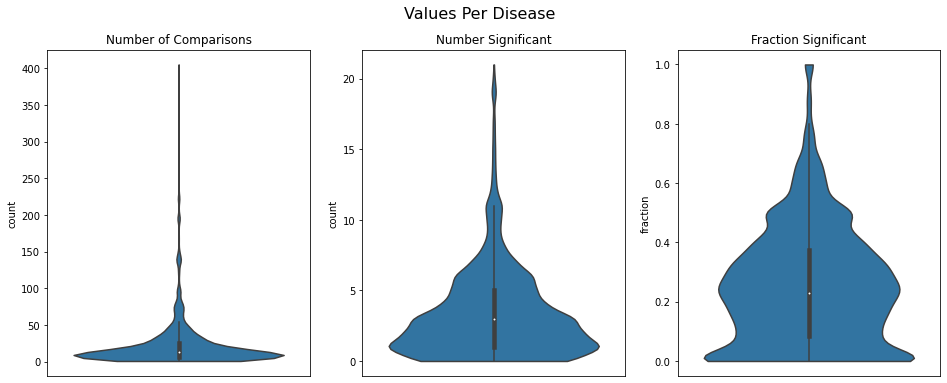

In [46]:
cc_to_dis_data = add_disease_wise_bonferroni_pval_correction(cc_to_dis_data, 0.25)

print("{:,} Comparisons".format(len(cc_to_dis_data)))
print("{:,} Number Significant".format(cc_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(cc_to_dis_data['is_sig'].sum() / len(cc_to_dis_data)))

plot_results(get_plot_data(cc_to_dis_data))

In [47]:
this_edge = comparisons_to_edges(cc_to_dis_data, 'cc', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
0,Q14916314,Q1947304,associated_with,computed,fishers_exact,0.000227,0.001361
1,Q14916314,Q954831,associated_with,computed,fishers_exact,0.000227,0.001361
2,Q14916314,Q189580,associated_with,computed,fishers_exact,0.000227,0.001361
6,Q21119330,Q3304152,associated_with,computed,fishers_exact,0.005437,0.239211
11,Q21119330,Q1047559,associated_with,computed,fishers_exact,0.005437,0.146789


In [48]:
new_edges.append(this_edge)

## Pathway associated_with Disease

In [49]:
pw_to_gene = (combo.query('start_label == "Pathway" and end_label == "Gene"')
                   .groupby('start_id')['end_id']
                   .apply(set)
                   .to_dict())
pw_to_gene = filter_tax(pw_to_gene)
pw_to_gene = filter_to_disese_genes(pw_to_gene)

pw_to_dis_data = run_all_compaisons('pw', 'disease', 'gene', pw_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

95,279 Comparisons
15,676 Number Significant
0.165 Fraction Significant


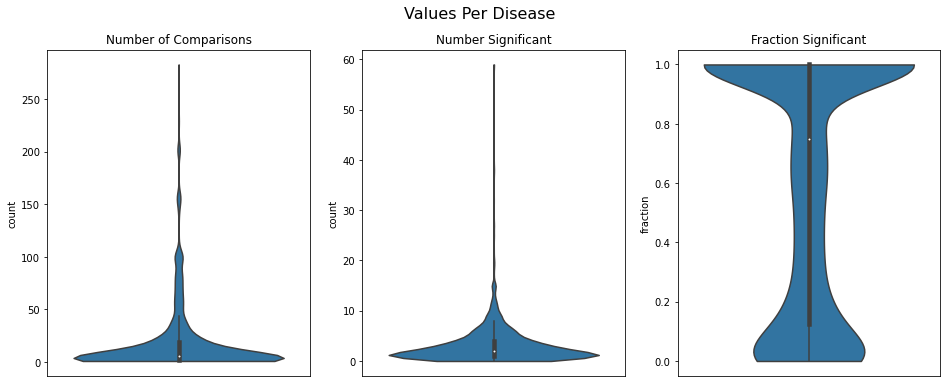

In [50]:
pw_to_dis_data = add_disease_wise_bonferroni_pval_correction(pw_to_dis_data, 0.25)

print("{:,} Comparisons".format(len(pw_to_dis_data)))
print("{:,} Number Significant".format(pw_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(pw_to_dis_data['is_sig'].sum() / len(pw_to_dis_data)))

plot_results(get_plot_data(pw_to_dis_data))

In [51]:
this_edge = comparisons_to_edges(pw_to_dis_data, 'pw', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
1,Q50400139,Q60195010,associated_with,computed,fishers_exact,0.011497,0.091972
10,Q50400139,Q53923559,associated_with,computed,fishers_exact,0.017199,0.137589
11,Q50400139,Q20409168,associated_with,computed,fishers_exact,0.011497,0.091972
15,Q50400139,Q20409189,associated_with,computed,fishers_exact,0.011497,0.091972
16,Q50400139,Q60195316,associated_with,computed,fishers_exact,0.000031,0.000771


In [52]:
new_edges.append(this_edge)

## Add in the new edges

In [53]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)
combo = combine_nodes_and_edges(nodes, edges)

new_edges = []

# Final Computation: Merge Gene/Protein

We will do the following:

1. Map all Proteins in edges to Genes
2. Drop edges with Mapped Proteins
3. Merge Xrefs on Merged Gene/Proteins

## 1. Mapping Proteins to Genes

In [54]:
# pun map cols are ['start_id': result_col, 'end_id': merge_map_col]
gene_to_prot = edges.query('type == "encodes"')[['start_id', 'end_id']]
gene_to_prot.head()

,start_id,end_id
460156,Q59963416,Q59963413
460157,Q59963424,Q59963422
460158,Q59963435,Q59963432
460159,Q59963447,Q59963444
460160,Q59963458,Q59963456


In [55]:
start_prot = combo.query('start_label == "Protein" and type != "encodes"')
end_prot = combo.query('end_label == "Protein" and type != "encodes"')

In [56]:
start_merge = pun_col(start_prot, gene_to_prot)
end_merge = pun_col(end_prot, gene_to_prot, False)

start_merge['comp_type'] = 'merge'
end_merge['comp_type'] = 'merge'

new_edges.append(start_merge)
new_edges.append(end_merge)

## 2. Removing edges with successful mappings

We're merging Proteins and Genes... Therefore we want to remove edges of Protein -> X or Y -> Protein.

However, some (primarly non-human) proteins may not be mappable via a protein to gene edge, so we
will keep those for now

In [57]:
found_prots = gene_to_prot['end_id'].tolist()
drop_idx = edges.query('start_id in @found_prots or end_id in @found_prots').index

print('{:,}'.format(len(edges)))
edges = edges.drop(drop_idx)
print('{:,}'.format(len(edges)))

2,390,468
1,302,748


In [58]:
len(pd.concat(new_edges)) + 476963

1374409

## 3. Merging the Xrefs in the nodes.

In [59]:
def combine_xrefs_and_set_label(combined_nodes, label):
    add_nodes = combine_group_cols_on_char(combined_nodes, ['id'], ['xrefs'], prog=False)
    add_nodes['label'] = label
    
    return add_nodes[['id', 'name', 'label', 'xrefs']]

In [60]:
mapped_prot_genes = gene_to_prot.stack().values

In [61]:
mrg = nodes.query('id in @mapped_prot_genes').merge(gene_to_prot, how='left', left_on ='id', right_on='end_id' )
mrg = mrg.rename(columns={'id':'old_id'})
mrg['start_id'] = mrg['start_id'].fillna(mrg['old_id'])
mrg = mrg.rename(columns={'start_id': 'id'})
mrg

,old_id,name,label,xrefs,id,end_id
0,Q59961560,fam-m protein,Protein,NaN,Q59961564,Q59961560
1,Q59961572,PIR protein,Protein,NaN,Q59961574,Q59961572
2,Q59961581,fam-l protein,Protein,NaN,Q59961583,Q59961581
3,Q59961590,fam-m protein,Protein,NaN,Q59961592,Q59961590
4,Q59961603,fam-m protein,Protein,NaN,Q59961605,Q59961603
...,...,...,...,...,...,...
393330,Q970156,Nucleolin,Protein,UniProt:P19338,Q18029887,Q970156
393331,Q986112,C-X-C motif chemokine ligand 10,Protein,UniProt:P02778,Q14907804,Q986112
393332,Q993804,Prolyl endopeptidase,Protein,UniProt:P48147,Q14911792,Q993804
393333,Q994646,Fas associated via death domain,Protein,UniProt:Q13158,Q14907137,Q994646


In [62]:
gene_id_to_xref = combine_xrefs_and_set_label(mrg, 'Gene').set_index('id')['xrefs'].to_dict()

nodes['xrefs'] = nodes['id'].map(gene_id_to_xref).fillna(nodes['xrefs'])

Some edges may have gone to both gene and protein. Since we have now mapped proteins to genes, they will be duplicated.

We will now drop any potential duplicates

In [63]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)

print('{:,}'.format(len(edges)))
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'], keep='first')
print('{:,}'.format(len(edges)))

2,200,194
2,005,623


# Remove mapper edges

Now that punning is complete, `subclass_of` and `encodes` edges should be removed

In [64]:
drop_idx = edges.query('type == "encodes" or type == "subclass_of"').index

print('{:,}'.format(len(edges)))
edges = edges.drop(drop_idx)
print('{:,}'.format(len(edges)))

2,005,623
1,962,316


# Check and save...

In [65]:
combo = combine_nodes_and_edges(nodes, edges)

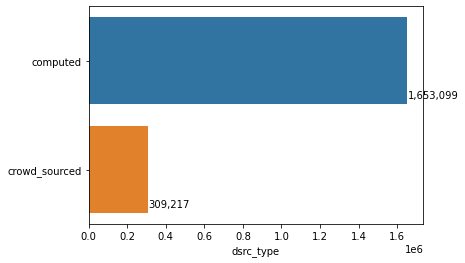

In [66]:
count_plot_h(edges['dsrc_type'])

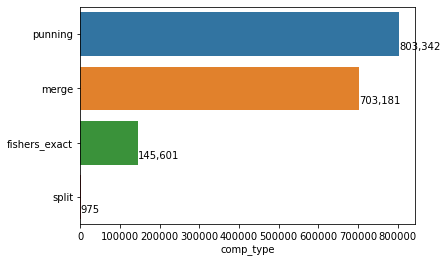

In [67]:
count_plot_h(edges['comp_type'])

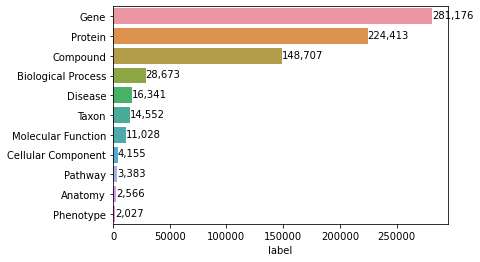

In [68]:
count_plot_h(nodes['label'])

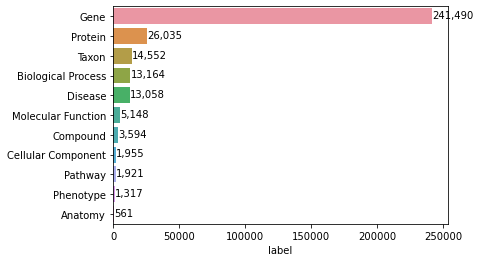

In [69]:
e_ids = edges[['start_id', 'end_id']].stack().values
nodes_filt = nodes.query('id in @e_ids')

count_plot_h(nodes_filt['label'])

In [70]:
meta_edges = combo['start_label'] + '_' + combo['type'] + '_' + combo['end_label']
meta_edges.nunique()

36

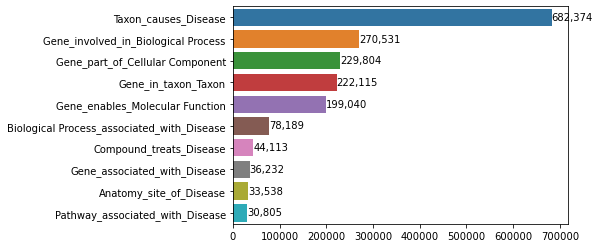

In [71]:
count_plot_h(meta_edges.value_counts().head(10))

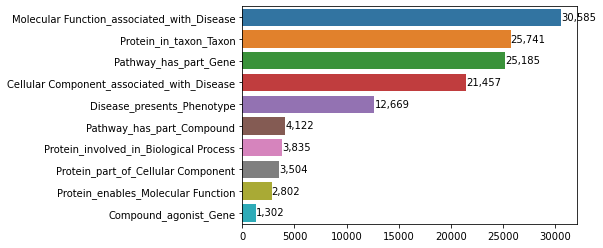

In [72]:
count_plot_h(meta_edges.value_counts().head(20).tail(10))

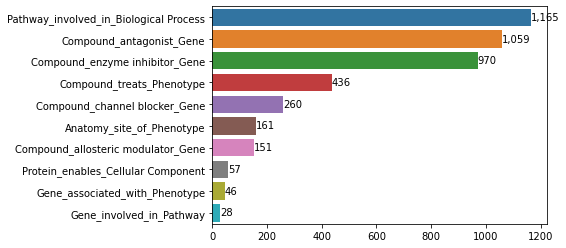

In [73]:
count_plot_h(meta_edges.value_counts().head(30).tail(10))

## Save the data

In [74]:
edges['source'] = 'WikiData'
edges['license'] = 'CC0 1.0'

In [75]:
this_file = '01d_WikiData_Compute'
out_dir = Path('../2_pipeline/').joinpath(this_file, 'out').resolve()

out_dir.mkdir(parents=True, exist_ok=True)

nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
edges.to_csv(out_dir.joinpath('edges.csv'), index=False)